## Import modules

In [4]:
import torch
from torch import optim
import signatory
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from lib.utils import sample_indices, to_numpy
from lib.augmentations import apply_augmentations
from lib.sigcwgan_data import get_data, get_var_dataset

from dataclasses import dataclass
from typing import List, Tuple

## Data preprocessing

### A dataclass for signature

In [2]:
@dataclass
class SigConfig:
    augmentations: Tuple
    depth: int

In [ ]:
def augment_path_and_compute_signatures(x: torch.Tensor, config: SigConfig) -> torch.Tensor:
    y = apply_augmentations(x, config.augmentations)
    return signatory.signature(y, config.depth, basepoint=config.basepoint) 

### A dataclass for the signature in SigCWGAN

In [3]:
@dataclass
class SigCWGANConfig:
    mc_size: int
    sig_config_future: SigConfig
    sig_config_past: SigConfig

    def sig_past(self, x):
        return augment_path_and_compute_signatures(x, self.sig_config_past)

    def sig_future(self, x):
        return augment_path_and_compute_signatures(x, self.sig_config_future)

## Data

### VAR dataset

Tensor shape before rolling: torch.Size([40000, 3])
Tensor shape after rolling: torch.Size([39995, 6, 3])


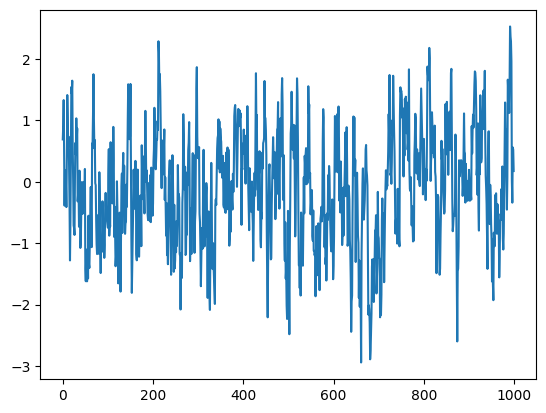

In [19]:
var_data = get_data('VAR',3, 3)
plt.plot(var_data[:1000,:1,0])

In [20]:
# def _rolling_window(x, x_lag, add_batch_dim=True):
#     if add_batch_dim:
#         x = x[None, ...]
#     return torch.cat([x[:, t:t + x_lag] for t in range(x.shape[1] - x_lag)], dim=0)
# def _get_data(data_type, p, q, **data_params):
#     if data_type == 'VAR':
#          _, normalized_data = get_var_dataset(
#             40000, batch_size=1, **data_params
#         )
#     assert normalized_data.shape[0] == 1
#     normalized_data = _rolling_window(normalized_data[0], p + q)
#     return normalized_data
# _var_data = _get_data('VAR', 3, 3)
# print(_var_data.shape)

## Linear regression
Estimate the conditional expectation
$$
\begin{aligned}
\mathbb{E}_{X_{future}\sim\mu} \left[S_M(X_{future})\right]
\end{aligned}
$$
by using linear regression
$$
\begin{aligned}
S_M(X_{future}) = L(S_M(X_{past}))+\epsilon.
\end{aligned}
$$

In [ ]:
def linea_regression_estimator(config, x_future, x_past):
    sig_past = config.sig_past(x_past)
    sig_future = config.sig_future(x_future)
    X, Y = to_numpy(sig_past), to_numpy(sig_future)
    linear_regression = LinearRegression()
    linear_regression.fit(X, Y)
    pred = torch.from_numpy(linear_regression.predict(X)).float().to(x_future.device)
    return pred

## Loss

In [ ]:
def sigcwgan_loss(sig_pred: torch.Tensor, sig_fake_conditional_expectation: torch.Tensor):
    return torch.norm(sig_pred - sig_fake_conditional_expectation, p=2, dim=1).mean()

## SigCWGAN model

### Commonly used parameter
- `p`: past window size
- `q`: future window size
- `mc_samples`: Number of Monte Carlo samples

In [ ]:
@dataclass
class SigCWGANParam:
    seed: int = 0
    batch_size: int = 200
    device: str = 'cuda'
    p: int = 3  
    q: int = 3
    hidden_dims: Tuple[int] = 3 * (50,)
    epochs: int = 1000
    mc_samples: int = 1000

# Used if one needs to calculate cross correlation
def is_multivariate(x):
    return True if x.shape[-1] > 1 else False